In [20]:
import pandas as pd
import numpy as np
from tensorflow import keras
import tensorflow as tf
from pydub import AudioSegment
from skimage import io, data
import io as fileio
import librosa
from librosa import display
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
import requests
import spotipy
import seaborn as sns
import matplotlib.pyplot as plt
from six.moves.urllib.request import urlopen
import urllib
%matplotlib inline

In [3]:
cnn_model = keras.models.load_model('cnn_model.h5')
cnn_model.summary()

W0908 08:28:53.477319 4563555776 deprecation.py:323] From /anaconda3/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:4149: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 109, 300)          201000    
_________________________________________________________________
elu (ELU)                    (None, 109, 300)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 109, 300)          1200      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 36, 300)           0         
_________________________________________________________________
dropout (Dropout)            (None, 36, 300)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 36, 150)           45150     
_________________________________________________________________
elu_1 (ELU)                  (None, 36, 150)           0

In [4]:
# get Spotify token 

def get_spotify_service():

    cid = ""
    secret = ""
    redirectURI = "http://localhost:8888/callback/"
    username = ""
    scope = 'user-library-read, playlist-read-private, user-library-read, user-read-currently-playing'

    token = util.prompt_for_user_token(username,
                                       scope,
                                       client_id=cid,
                                       client_secret=secret,
                                       redirect_uri=redirectURI)

    service = spotipy.Spotify(auth=token)

    return service

In [5]:
# Search artist and get URI

def search_artist(artist):

    cid = "" 
    secret = ""
    username = ""

    client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret) 
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    scope = 'user-library-read playlist-read-private, user-library-read, user-read-currently-playing'

    username = ""
    spotify = get_spotify_service()

    artist = str(artist)

    artist_id = sp.search(q='artist:' + artist, type='artist')
    artist_uri = artist_id['artists']['items'][0]['external_urls']['spotify'].split("/")[-1]
    
    return artist_uri

In [6]:
# Search artist and get URI

def search_artist(artist):

    cid = "" 
    secret = ""
    username = ""

    client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret) 
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    scope = 'user-library-read playlist-read-private, user-library-read, user-read-currently-playing'

    username = ""
    spotify = get_spotify_service()

    artist = str(artist)

    artist_id = sp.search(q='artist:' + artist, type='artist')
    artist_uri = artist_id['artists']['items'][0]['external_urls']['spotify'].split("/")[-1]
    
    return artist_uri

In [7]:
# Get album list via artist URI

def get_album_list(artist_uri):
    
    cid = "" 
    secret = ""
    username = ""
    
    client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret) 
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    scope = 'user-library-read playlist-read-private, user-library-read, user-read-currently-playing'

    username = ""
    spotify = get_spotify_service()
    
    artist_albums = sp.artist_albums(artist_uri, album_type='album')
    album_count = len(artist_albums['items'])
    album_list_urls = []
    album_list_title = []

    for i in range(album_count):
        album_list_urls.append(artist_albums['items'][i]['external_urls']['spotify'])
        album_list_title.append(artist_albums['items'][i]['name'])

    return album_list_title, album_list_urls

In [8]:
# Get tracks of album via album URI

def album_tracks(album_uri):
    
    cid = "" 
    secret = ""
    username = ""
    
    client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret) 
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    scope = 'user-library-read playlist-read-private, user-library-read, user-read-currently-playing'

    spotify = get_spotify_service()
    
    track_title = []
    track_url = []
    
    album_tracks = sp.album_tracks(album_uri)
    
    for i in range(len(album_tracks['items'])):
        track_title.append(album_tracks['items'][i]['name'])
        track_url.append(album_tracks['items'][i]['preview_url'])
    print(track_title)    
    return track_title, track_url

In [9]:
# End-to-end of getting track from artist input

def albums(artist):
        
    cid = ""
    secret = ""
    redirectURI = "http://localhost:8888/callback/"
    username = ""
    scope = 'user-library-read, playlist-read-private, user-library-read, user-read-currently-playing'  
    spotify = get_spotify_service()
    
    artist_uri = search_artist(artist)
    album_title, album_urls = get_album_list(artist_uri)
    print(album_title)
    choose = int(input('Please select album:\n'))
    print('You have selected: {}\n'.format(album_title[choose]))
    album_uri = album_urls[choose]
    track_list, track_url = album_tracks(album_uri)
    track_choose = int(input('Please select track:\n'))
    print("Great choice! Now playing: {}'s {}\n".format(artist.capitalize(), track_list[track_choose]))
    track_url = track_url[track_choose]
    preview_song = AudioSegment.from_mp3(fileio.BytesIO(urlopen(track_url).read()))[:30000]
    filename = artist+'_'+track_list[track_choose].lower()
    preview_song.export("./capture/tracks/{}.wav".format(filename, format="wav"))
    return filename, preview_song

In [15]:
tags = {
    'shoegazeanddreampop': ('guitar loop', 'drone'),
    'dance': ('trance loop', 'house loop', 'techno loop', 'tech house loop', 'dance loop', 'dubstep loop'),
    'classical': ('violin', 'piano', 'orchestra', 'concert band', 'woodwinds', 'strings'),
    'electronica': ('lofi', 'chillhop', 'synthwave', 'electronic'),
    'rnb': ('hiphop', 'r&b'),
    'pop': ('pop loop', 'pop vocals'),
    'rock': ('rock loop', 'rock loop')
}

In [25]:
"""
Full function of Spotify selection and running of model

"""

def run_cnn_model(artist, duration=5, fs=22050, channels=2):
    filename, predict_song = albums(artist)
    y, sr = librosa.load('./capture/tracks/{}.wav'.format(filename))
    D = librosa.feature.melspectrogram(y, sr=sr, n_mels=96)
        
    plt.figure(figsize=(12, 4))
    ax = plt.axes()
    ax.set_axis_off()
    librosa.display.specshow(librosa.power_to_db(D, ref=np.max), cmap='seismic', y_axis='mel', x_axis='time')
    plt.savefig('./capture/spectros/{}.wav'.format(filename)+'.png', bbox_inches='tight', transparent=False, pad_inches=0.0 )
    plt.close()
    img = io.imread('./capture/spectros/{}.wav.png'.format(filename), as_gray=True)
    img = img.reshape(1, img.shape[0], img.shape[1])
    cnn_test_result = cnn_model.predict(img)
    cnn_pd = pd.DataFrame(cnn_test_result)
    cnn_pd.columns = ['classical', 'dance', 'electronica', 'pop', 'rnb', 'rock', 'shoegazeanddreampop']
    plt.figure(figsize=(10,4))
    sns.barplot(x=cnn_pd.columns, y=cnn_pd.iloc[0,:])
    genre = cnn_pd.T.sort_values(0, ascending=False).index[0]
    print(genre)
    
    search = str(np.random.choice(tags[genre]))
    preview_ids = []
    preview_urls = []
    r = requests.get("https://freesound.org/apiv2/search/text/?query={}&token=4GqIhwqd8DhNYeNM7r0SWp4kvEXrKDOe3ZACyifu".format(search))
    results = r.json()['results']

    for i in range(len(results)):
        preview_ids.append(results[i]['id'])
    
    for i in preview_ids:
        preview_urls.append(requests.get('https://freesound.org/apiv2/sounds/{}/?token=4GqIhwqd8DhNYeNM7r0SWp4kvEXrKDOe3ZACyifu'.format(i)).json()['previews']['preview-hq-mp3'])

    return preview_urls

['The Getaway', "I'm with You", 'Stadium Arcadium', 'By the Way', 'By the Way (Deluxe Edition)', 'Californication', 'Californication (Deluxe Edition)', 'One Hot Minute (Deluxe Edition)', 'One Hot Minute', 'Blood Sugar Sex Magik (Deluxe Edition)', 'Blood Sugar Sex Magik', "Mother's Milk", 'The Uplift Mofo Party Plan', 'Freaky Styley', 'Red Hot Chili Peppers']
Please select album:
5
You have selected: Californication

['Around the World', 'Parallel Universe', 'Scar Tissue', 'Otherside', 'Get on Top', 'Californication', 'Easily', 'Porcelain', 'Emit Remmus', 'I Like Dirt', 'This Velvet Glove', 'Savior', 'Purple Stain', 'Right on Time', "Road Trippin'"]
Please select track:
5
Great choice! Now playing: Red hot chilli peppers's Californication

rock


['https://freesound.org/data/previews/432/432149_8713024-hq.mp3',
 'https://freesound.org/data/previews/432/432148_8713024-hq.mp3',
 'https://freesound.org/data/previews/101/101121_1657645-hq.mp3',
 'https://freesound.org/data/previews/423/423269_404624-hq.mp3',
 'https://freesound.org/data/previews/475/475657_2866779-hq.mp3',
 'https://freesound.org/data/previews/477/477475_7785430-hq.mp3',
 'https://freesound.org/data/previews/66/66956_649468-hq.mp3',
 'https://freesound.org/data/previews/256/256256_233371-hq.mp3',
 'https://freesound.org/data/previews/171/171167_3162775-hq.mp3',
 'https://freesound.org/data/previews/432/432150_8713024-hq.mp3',
 'https://freesound.org/data/previews/432/432264_8713024-hq.mp3',
 'https://freesound.org/data/previews/470/470766_5873027-hq.mp3',
 'https://freesound.org/data/previews/423/423278_404624-hq.mp3',
 'https://freesound.org/data/previews/37/37867_382028-hq.mp3',
 'https://freesound.org/data/previews/331/331876_5829171-hq.mp3']

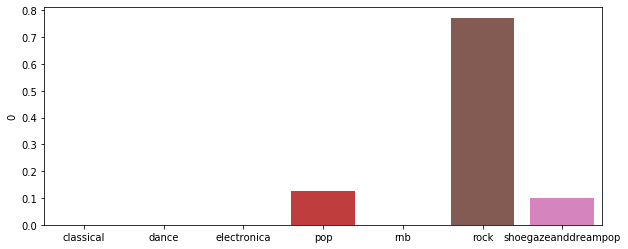

In [26]:
run_cnn_model('red hot chilli peppers')